# Project: Funnel Analysis

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
import graphviz

%matplotlib inline
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Table of Contents
  1. [Read Data](#readdata)
  2. [Funnel Conversion Rate](#funnelconversionrate)
  3. [Other Insights](#otherinsights)

<a id='read_data'></a>
## Read Data

In [2]:
# Since 'user_id' is the key of all the tables, change all the index in tables to be 'user_id'.
data = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/user_table.csv', index_col='user_id')
data.head()

,date,device,sex
user_id,,,
450007,2015-02-28,Desktop,Female
756838,2015-01-13,Desktop,Male
568983,2015-04-09,Desktop,Male
190794,2015-02-18,Desktop,Female
537909,2015-01-15,Desktop,Male


In [3]:
home = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/home_page_table.csv',index_col='user_id')
search = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/search_page_table.csv',index_col='user_id')
pay = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/payment_page_table.csv',index_col='user_id')
confirmation = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/5. Funnel_Analysis/payment_confirmation_table.csv',index_col='user_id')

In [4]:
# add one column 'page' to the 'data' to show the status 
data.loc[home.index,'page'] = home['page']
data.loc[search.index,'page'] = search['page']
data.loc[pay.index,'page'] = pay['page']
data.loc[confirmation.index, 'page'] = confirmation['page']
data.head()

,date,device,sex,page
user_id,,,,
450007,2015-02-28,Desktop,Female,home_page
756838,2015-01-13,Desktop,Male,home_page
568983,2015-04-09,Desktop,Male,search_page
190794,2015-02-18,Desktop,Female,search_page
537909,2015-01-15,Desktop,Male,home_page


In [7]:
# change the page name to make it more clear
data.rename(columns = {'page':'final_page'}, inplace = True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 450007 to 438929
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        90400 non-null  object
 1   device      90400 non-null  object
 2   sex         90400 non-null  object
 3   final_page  90400 non-null  object
dtypes: object(4)
memory usage: 3.4+ MB


In [14]:
# change string to ordered-categorical feature
pages = ["home_page","search_page","payment_page","payment_confirmation_page"]
data["final_page"] = data.final_page.astype("category")

In [16]:
#change the date from object to datetime
data['date']=pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 450007 to 438929
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        90400 non-null  datetime64[ns]
 1   device      90400 non-null  object        
 2   sex         90400 non-null  object        
 3   final_page  90400 non-null  category      
dtypes: category(1), datetime64[ns](1), object(2)
memory usage: 2.8+ MB


<a id='funnelconversionrate'></a>
## Funnel Conversion Rate

A full picture of funnel conversion rate for different devices: desktop and mobile

In [20]:
#define a new dataframe to show the stay, convert_rate etc.

def conversion_rates(df):
    stage_counts = df.final_page.value_counts()
    # #users converts from current page
    convert_from = stage_counts.copy()

    total = df.shape[0]
    for page in stage_counts.index:
        # how many users stop at current page
        n_left = stage_counts.loc[page]
        n_convert = total - n_left
        convert_from[page] = n_convert
        total = n_convert

    cr = pd.concat([stage_counts,convert_from],axis=1,keys=["n_drop","n_convert"])
    cr["convert_rates"] = cr.n_convert.astype(np.float)/(cr.n_drop + cr.n_convert)
    cr['drop_rates'] = 1 - cr.convert_rates

    return cr

In [22]:
# convert rate for desktop and mobile
data.groupby('device').apply(conversion_rates)

n_drop  n_convert  convert_rates  \
device                                                                
Desktop home_page                   30100      30100       0.500000   
        search_page                 27090       3010       0.100000   
        payment_page                 2860        150       0.049834   
        payment_confirmation_page     150          0       0.000000   
Mobile  home_page                   15100      15100       0.500000   
        search_page                 12080       3020       0.200000   
        payment_page                 2718        302       0.100000   
        payment_confirmation_page     302          0       0.000000   

                                   drop_rates  
device                                         
Desktop home_page                    0.500000  
        search_page                  0.900000  
        payment_page                 0.950166  
        payment_confirmation_page    1.000000  
Mobile  home_page                    0.500000  
        search_page                  0.800000  
        payment_page                 0.900000  
        payment_confirmation_page    1.000000

In [24]:
data.groupby('device')['final_page'].apply(lambda s: s.value_counts(normalize=True)).unstack()

,home_page,search_page,payment_page,payment_confirmation_page
device,,,,
Desktop,0.5,0.45,0.047508,0.002492
Mobile,0.5,0.40,0.090000,0.010000


<a id='otherinsights'></a>
## Other Insights

Some insights on what the product team should focus on in order to improve conversion rate as well as anything that could help improve conversion rate.

### Impact of data

In [28]:
# Transfer column 'weekday' to be day_name and 'page' to be int (0 or 1)
data_=data.copy()
data_['weekday']=data_['date'].dt.day_name()
data_['final_page']= (data_['final_page']=='payment_confirmation_page').astype(int)

data_.head()

,date,device,sex,final_page,weekday
user_id,,,,,
450007,2015-02-28,Desktop,Female,0,Saturday
756838,2015-01-13,Desktop,Male,0,Tuesday
568983,2015-04-09,Desktop,Male,0,Thursday
190794,2015-02-18,Desktop,Female,0,Wednesday
537909,2015-01-15,Desktop,Male,0,Thursday


In [30]:
# check the influence of date(weekday) by calculating averaged conversion rate of everyday
weekday = data_.groupby('weekday')['final_page'].agg(['count','mean']).sort_values(by='mean', ascending = False)
weekday.loc['Average'] = weekday.mean()
weekday['compared with the average'] = (weekday['mean']-weekday.loc['Average','mean'])/weekday.loc['Average','mean']
weekday

,count,mean,compared with the average
weekday,,,
Monday,12955.000000,0.005944,0.188817
Saturday,12801.000000,0.005468,0.093744
Tuesday,12697.000000,0.005434,0.086950
Thursday,13444.000000,0.004909,-0.018078
Sunday,12922.000000,0.004798,-0.040326
Friday,12750.000000,0.004235,-0.152880
Wednesday,12831.000000,0.004209,-0.158227
Average,12914.285714,0.005000,0.000000


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

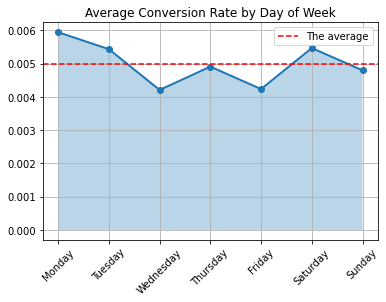

In [13]:
# visualization of influence of weekday
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday','Average']
weekday1 = weekday.reindex(cats)
x = weekday1.drop('Average').index
y = weekday1.drop('Average')['mean']

fig,ax = plt.subplots()
plt.grid(True)
ax.plot(x,y,lw=2,marker='o')
ax.fill_between(x,0,y,alpha=0.3)

plt.axhline(y = weekday1.loc['Average','mean'],color = 'r', linestyle = '--',label='The average')
plt.legend()
plt.title('Average Conversion Rate by Day of Week')
plt.xticks(rotation=45)


### Impact of Device

In [14]:
# check the device influence
device = data_.groupby('device')['page'].agg(['count','mean']).sort_values(by='mean')
device.loc['Difference']=(device.loc['Mobile']-device.loc['Desktop'])/device.loc['Desktop']
device

,count,mean
device,,
Desktop,60200.000000,0.002492
Mobile,30200.000000,0.010000
Difference,-0.498339,3.013333


### Impact of Sex

In [15]:
# check the sex influence
sex = data_.groupby('sex')['page'].agg(['count','mean']).sort_values(by='mean')
sex.loc['Difference']=(sex.loc['Male']-sex.loc['Female'])/sex.loc['Male']
sex

,count,mean
sex,,
Male,45325.000000,0.004655
Female,45075.000000,0.005347
Difference,0.005516,-0.148515


Summary:
1. The first day of the typical workweek produced about 18% higher conversion rate than the average.And Friday's conversion rate show 15% lower than the average. This make sense, since people work harder at the begining of the weak compared with on Friday.
2. The count of using mobile is  50% less than that of desktop users. 

### Statistical Model

In [41]:
X = data.copy()
X.head()

,date,device,sex,final_page
user_id,,,,
450007,2015-02-28,Desktop,Female,home_page
756838,2015-01-13,Desktop,Male,home_page
568983,2015-04-09,Desktop,Male,search_page
190794,2015-02-18,Desktop,Female,search_page
537909,2015-01-15,Desktop,Male,home_page


In [42]:
X['from_mobile'] = (X.device == 'Mobile').astype(int)
del X['device']

X['is_male'] = (X.sex == 'Male').astype(int)
del X['sex']

X['weekday'] = X.date.dt.day_name()
del X['date']

X['converted'] = (X.final_page == 'payment_confirmation_page').astype(int)
del X['final_page']

X.head()

,from_mobile,is_male,weekday,converted
user_id,,,,
450007,0,0,Saturday,0
756838,0,1,Tuesday,0
568983,0,1,Thursday,0
190794,0,0,Wednesday,0
537909,0,1,Thursday,0


In [43]:
X = pd.get_dummies(X)
X.head()

,from_mobile,is_male,converted,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
user_id,,,,,,,,,,
450007,0,0,0,0,0,1,0,0,0,0
756838,0,1,0,0,0,0,0,0,1,0
568983,0,1,0,0,0,0,0,1,0,0
190794,0,0,0,0,0,0,0,0,0,1
537909,0,1,0,0,0,0,0,1,0,0


In [44]:
y = X['converted']
X = X.loc[:,X.columns != 'converted']

In [47]:
scores, pvalues = chi2(X,y)
pd.DataFrame({'chi2_score':scores,'chi2_pvalue':pvalues},index=X.columns).sort_values(by='chi2_score',ascending=False)

,chi2_score,chi2_pvalue
from_mobile,151.758794,7.153913e-35
weekday_Monday,2.318821,1.278169e-01
weekday_Wednesday,1.615497,2.037208e-01
weekday_Friday,1.498670,2.208761e-01
is_male,1.082703,2.980938e-01
weekday_Saturday,0.564341,4.525166e-01
weekday_Tuesday,0.481501,4.877434e-01
weekday_Sunday,0.105964,7.447867e-01
weekday_Thursday,0.022253,8.814147e-01


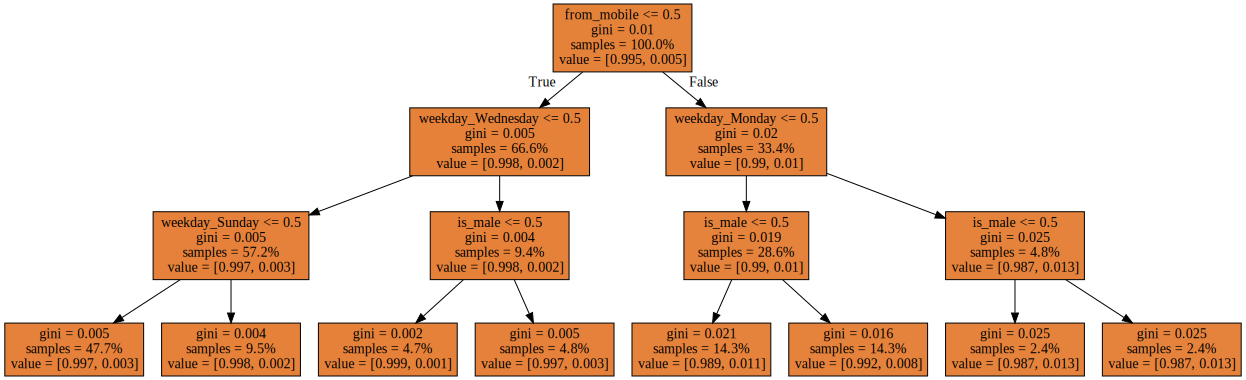

In [59]:
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)
dot_data = export_graphviz(dt,feature_names=X.columns,
                proportion=True,leaves_parallel=True,filled=True)
graph = graphviz.Source(dot_data)
graph

It can be seen from Decision Tree, to reach the leaf node with highest converstion rate, the path is monday and from desktop.